In [1]:
from lbmpy.session import *
from lbmpy.phasefield.analytical import *
from functools import partial

# Analytical checks for N-Phase model

### Formulation of free energy

In the next cell you can inspect the formulation of the free energy functional. 
Bulk and interface terms can be viewed separately.

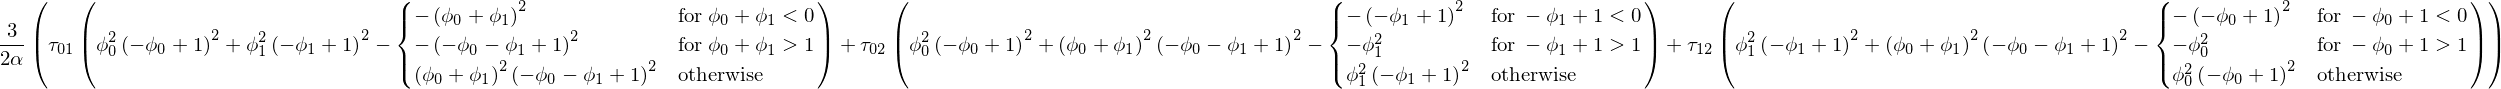

In [2]:
num_phases = 3
order_params = symbolic_order_parameters(num_symbols=num_phases-1)
f2 = partial(n_phases_correction_function, beta=1)
F = free_energy_functional_n_phases(order_parameters=order_params, 
                                    include_interface=False, f2=f2,
                                    include_bulk=True )
F

### Analytically checking the phase transition profile

First we define the order parameters and free energy, including bulk and interface terms:

In [3]:
F = free_energy_functional_n_phases(order_parameters=symbolic_order_parameters(num_symbols=num_phases-1))

Then we automatically derive the differential equations for the chemial potential $\mu$

In [4]:
mu_diff_eq = chemical_potentials_from_free_energy(F, order_params)

# there is one equation less than phases
assert len(mu_diff_eq) == num_phases - 1

# show the first one
mu_diff_eq[0]

                                                                              
                                                                              
3⋅α⋅τ₀ ₁⋅D(D(phi_1)) - 6⋅α⋅τ₀ ₂⋅D(D(phi_0)) - 3⋅α⋅τ₀ ₂⋅D(D(phi_1)) - 3⋅α⋅τ₁ ₂⋅
                                                                              

                   3             2                2                2          
              12⋅φ₀ ⋅τ₀ ₂   18⋅φ₀ ⋅φ₁⋅τ₀ ₁   18⋅φ₀ ⋅φ₁⋅τ₀ ₂   18⋅φ₀ ⋅φ₁⋅τ₁ ₂  
D(D(phi_1)) + ─────────── - ────────────── + ────────────── + ────────────── -
                   α              α                α                α         

      2                2                2                2                    
 18⋅φ₀ ⋅τ₀ ₂   18⋅φ₀⋅φ₁ ⋅τ₀ ₁   18⋅φ₀⋅φ₁ ⋅τ₀ ₂   18⋅φ₀⋅φ₁ ⋅τ₁ ₂   18⋅φ₀⋅φ₁⋅τ₀ 
 ─────────── - ────────────── + ────────────── + ────────────── + ────────────
      α              α                α                α                α     

                                                 

Next we check, that the $tanh$ is indeed a solution of this equation...

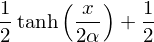

In [5]:
x = sp.symbols("x")
expected_profile = analytic_interface_profile(x)
expected_profile

... by inserting it for $\phi_0$, and setting all other order parameters to zero

In [6]:
# zero other parameters
diff_eq = mu_diff_eq[0].subs({p: 0 for p in order_params[1:]})

# insert analytical solution
diff_eq = diff_eq.subs(order_params[0], expected_profile)
diff_eq.factor()

        ⎛   2                                       3⎛ x ⎞       ⎛ x ⎞⎞ 
-3⋅τ₀ ₂⋅⎜4⋅α ⋅D(D(tanh(x/(2*alpha))/2 + 1/2)) - tanh ⎜───⎟ + tanh⎜───⎟⎟ 
        ⎝                                            ⎝2⋅α⎠       ⎝2⋅α⎠⎠ 
────────────────────────────────────────────────────────────────────────
                                  2⋅α                                   

finally the differentials have to be evaluated...

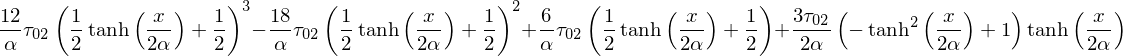

In [7]:
from pystencils.fd import evaluate_diffs
diff_eq = evaluate_diffs(diff_eq, x)
diff_eq

.. and the result simplified...

In [8]:
assert diff_eq.expand() == 0
diff_eq.expand()

...and indeed the expected tanh profile satisfies this differential equation.

Next lets check for the interface between phase 0 and phase 1:

In [9]:
for diff_eq in mu_diff_eq:
    eq = diff_eq.subs({order_params[0]: expected_profile,
                       order_params[1]: 1 - expected_profile})
    assert evaluate_diffs(eq, x).expand() == 0

### Checking the surface tensions parameters

Computing the excess free energy per unit area of an interface between two phases.
This should be exactly the surface tension parameter.

In [10]:
order_params = symbolic_order_parameters(num_symbols=num_phases-1)
F = free_energy_functional_n_phases(order_parameters=order_params)

In [11]:
two_phase_free_energy = F.subs({order_params[0]: expected_profile,
                                order_params[1]: 1 - expected_profile})

# Evaluate differentials and simplification
two_phase_free_energy = sp.simplify(evaluate_diffs(two_phase_free_energy, x))

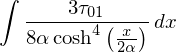

In [12]:
excess_free_energy = sp.Integral(two_phase_free_energy, x)
excess_free_energy

Sympy cannot integrate this automatically - help with a manual substitution $\frac{x}{2\alpha} \rightarrow u$

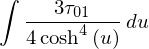

In [13]:
coshTerm = list(excess_free_energy.atoms(sp.cosh))[0]
transformed_int = excess_free_energy.transform(coshTerm.args[0], sp.Symbol("u", real=True))
transformed_int

Now the integral can be done:

In [14]:
result = sp.integrate(transformed_int.args[0], (transformed_int.args[1][0], -sp.oo, sp.oo))
assert result == symmetric_symbolic_surface_tension(0,1)
result